In [1]:
from IPython.display import HTML, display
HTML(open('../style.css').read())

# Implementing an Earley Parser

In [2]:
__file__ = 'main'

In [3]:
from IPython.display import HTML, display
import ply.lex as lex
import ply.yacc as yacc
import re
import graphviz

In [4]:
tokens = ['VARIABLE', 'TERMINAL', 'LITERAL']

t_VARIABLE = r'[a-z][a-z0-9_]*'
t_TERMINAL = r'[A-Z][A-Z0-9_]*'
t_ignore = ' \t\r'

def t_LITERAL(t):
    r"'.'"
    t.value = t.value[1] # Strip quotes
    return t

def t_newline(t):
    r'\n'
    t.lexer.lineno += 1

def t_error(t):
    # Keeping original error printing style
    print(f"Illegal character '{t.value[0]}' in line {t.lineno}.")
    t.lexer.skip(1)

literals = [':', ';']
meta_lexer = lex.lex()

In [5]:
def p_grammar_one(p):
    "grammar : rule"
    p[0] = [p[1]]

def p_grammar_more(p):
    "grammar : rule grammar"
    p[0] = [p[1]] + p[2]

def p_rule(p):
    "rule : VARIABLE ':' item_list ';'"
    p[0] = [p[1]] + p[3]

def p_item_list_zero(p):
    "item_list : "
    p[0] = []

def p_item_list_more(p):
    "item_list : item item_list"
    p[0] = [p[1]] + p[2]

def p_item_variable(p):
    "item : VARIABLE"
    p[0] = p[1]

def p_item_terminal(p):
    "item : TERMINAL"
    p[0] = p[1]

def p_item_literal(p):
    "item : LITERAL"
    p[0] = p[1]

def p_error(t):
    if t:
        print(f'Syntax error at token "{t.value}" in line {t.lineno}.')
    else:
        print('Syntax error at end of input.')

# Build the meta-parser
meta_parser = yacc.yacc(write_tables=False, debug=False)

In [6]:
def tokenize(s: str) -> list[tuple[str, str]]:
    '''Transform the string s into a list of (type, value) pairs.'''
    lexSpec = r'''([ \t]+)        |  # blanks and tabs
                  ([1-9][0-9]*|0) |  # number
                  ([()])          |  # parentheses 
                  ([-+*/])        |  # arithmetical operators
                  (.)                # unrecognized character
               '''
    tokenList = re.findall(lexSpec, s, re.VERBOSE)
    result    = []
    for ws, number, parenthesis, operator, error in tokenList:
        if ws:        
            continue
        elif number:
            result += [ ('NUMBER', number) ]
        elif parenthesis:
            # For literals like '(', the type is '(' and value is '('
            result += [ (parenthesis, parenthesis) ]
        elif operator:
            # For literals like '+', the type is '+' and value is '+'
            result += [ (operator, operator) ]
        else:
            result += [ (f'ERROR({error})', error) ]
    return result

In [7]:
class EarleyItem():
    def __init__(self, variable: str, alpha: tuple[str, ...], beta: tuple[str, ...], index: int) -> None:
        self.mVariable = variable
        self.mAlpha    = alpha
        self.mBeta     = beta
        self.mIndex    = index
        # New: Store backpointers. Set of (predecessor_item, child_node)
        self.mBackpointers: set[tuple[EarleyItem, EarleyItem | tuple]] = set()
    
    def __eq__(self, other: object) -> bool:
        # Crucial: Equality MUST ignore mBackpointers to allow state merging
        return isinstance(other, EarleyItem)     and \
               self.mVariable == other.mVariable and \
               self.mAlpha    == other.mAlpha    and \
               self.mBeta     == other.mBeta     and \
               self.mIndex    == other.mIndex
    
    def __ne__(self, other: object):
        return not self.__eq__(other)
    
    def __hash__(self):
        # Hash only the core properties
        alphaStr = ' '.join(self.mAlpha)
        betaStr  = ' '.join(self.mBeta)
        return hash((self.mVariable, alphaStr, betaStr, self.mIndex))
    
    def __repr__(self):
        alphaStr = ' '.join(self.mAlpha)
        betaStr  = ' '.join(self.mBeta)
        return f'<{self.mVariable} → {alphaStr} • {betaStr}, {self.mIndex}>'

    def isComplete(self) -> bool:
        return len(self.mBeta) == 0

    def sameVar(self, c: str) -> bool:
        return len(self.mBeta) > 0 and self.mBeta[0] == c

    def scan(self, T: str) -> bool:
        # Updated: Check if the next symbol in rule matches the token TYPE (T)
        if len(self.mBeta) > 0:
            return self.mBeta[0] == T
        return False

    def nextVar(self) -> str | None:
        if len(self.mBeta) > 0:
            var = self.mBeta[0]
            # Variables are lowercase and not quoted literals
            if len(var) > 0 and var[0] != "'" and var.islower():
                return var
        return None

    def moveDot(self):
        return EarleyItem(self.mVariable, 
                          self.mAlpha + (self.mBeta[0],), 
                          self.mBeta[1:], 
                          self.mIndex)

In [8]:
class Grammar():
    def __init__(self, Rules: list[list[str]]):
        self.mRules = Rules   

    def startItem(self) -> EarleyItem:
        return EarleyItem('Start', (), (self.startVar(),), 0)

    def finishItem(self) -> EarleyItem:
        return EarleyItem('Start', (self.startVar(),), (), 0)

    def startVar(self) -> str:
        return self.mRules[0][0]

    def toString(self) -> str:
        result = ''
        for head, *body in self.mRules:
            result += f'{head}: {body};\n'
        return result
        
    def __str__(self):
        return self.toString()

In [9]:
class EarleyParser():
    def __init__(self, grammar, TokenList):
        self.mGrammar   = grammar 
        # mString now stores (Type, Value) tuples
        self.mString    = [None] + TokenList 
        # Use Dict[EarleyItem, EarleyItem] to retrieve existing items and update them
        self.mStateList = [{} for i in range(len(TokenList)+1)] 
        
        print('Grammar:\n')
        print(self.mGrammar)
        print(f'Input: {self.mString}\n')
        
        start = self.mGrammar.startItem()
        self.mStateList[0][start] = start

    def parse(self):
        "run Earley's algorithm"
        print("starting...")
        n = len(self.mString) - 1 
        for i in range(0, n+1):
            if i + 1 <= n:
                next_token = self.mString[i+1]
            else:
                next_token = 'EOF'
            print('_' * 80)
            print(f'next token = {next_token}')
            print('_' * 80)
            change = True
            while change:
                change = self.complete(i)
                change = self.predict(i) or change
            self.scan(i)
            
            # print state
            print(f'\nQ{i}:')
            Qi = self.mStateList[i]
            for item in Qi.values(): 
                print(item)
            if i + 1 <= n:
                print(f'\nQ{i+1}:')
                Qip1 = self.mStateList[i+1]
                for item in Qip1.values(): 
                    print(item)
        
        finish = self.mGrammar.finishItem()
        final_state = self.mStateList[-1]
        if finish in final_state:
            print('Parsing successful!')
            # Return the actual item from the set so we have its backpointers
            return final_state[finish]
        else:
            print('Parsing failed!')
            return None

    def complete(self, i: int) -> bool:
        change = False
        added  = True
        Qi     = self.mStateList[i]
        
        # We need to loop until no more items (or backpointers) are added
        while added:
            added = False
            # We collect additions in a separate dict to safely iterate
            new_additions = {}
            
            for item in list(Qi.values()):
                if item.isComplete():
                    C  = item.mVariable
                    j  = item.mIndex
                    Qj = self.mStateList[j]
                    
                    for prevItem in Qj.values():
                        if prevItem.sameVar(C):
                            moved = prevItem.moveDot()
                            source = (prevItem, item) # Backpointer: (Prev, Child)
                            
                            # Check where to add this
                            target_item = None
                            
                            # Is it already in Qi?
                            if moved in Qi:
                                target_item = Qi[moved]
                            # Is it in our current new batch?
                            elif moved in new_additions:
                                target_item = new_additions[moved]
                            else:
                                # It's completely new
                                target_item = moved
                                new_additions[moved] = moved
                            
                            # Add the backpointer
                            if source not in target_item.mBackpointers:
                                target_item.mBackpointers.add(source)
                                # If the item was already in Qi, adding a backpointer 
                                # technically changes the 'derivation' but not the state set size.
                                # However, Earley loop condition usually tracks set size.
                                # We flag 'added' if the ITEM itself is new.
                                if moved not in Qi:
                                    added = True
            
            # If we found completely new items, add them to Qi and print
            if new_additions:
                change = True
                print("completion:")
                for it in new_additions.values():
                    if it not in Qi:
                        print(f'{it} added to Q{i}')
                        Qi[it] = it
                    else:
                        # Logic to merge if it was in Qi but we added backpointers is handled above
                        pass
                        
        return change

    def predict(self, i: int) -> bool:
        change = False
        added  = True
        Qi     = self.mStateList[i]
        
        while added:
            added = False
            new_items = {}
            
            for item in list(Qi.values()):
                c = item.nextVar()
                if c is not None:
                    for rule in self.mGrammar.mRules:
                        if c == rule[0]:
                            newItem = EarleyItem(c, (), tuple(rule[1:]), i)
                            if newItem not in Qi and newItem not in new_items:
                                new_items[newItem] = newItem
                                added = True
            
            if new_items:
                change = True
                print("prediction:")
                for it in new_items.values():
                    print(f'{it} added to Q{i}')
                    Qi[it] = it
                    
        return change

    def scan(self, i: int) -> None:
        Qi = self.mStateList[i]
        n  = len(self.mString) - 1 
        
        if i + 1 <= n:
            token_tuple = self.mString[i+1] # (Type, Value)
            token_type  = token_tuple[0]
            
            for item in list(Qi.values()):
                if item.scan(token_type):
                    moved = item.moveDot()
                    source = (item, token_tuple) # Backpointer: (Prev, (Type, Value))
                    
                    target_state = self.mStateList[i+1]
                    
                    if moved in target_state:
                        target_state[moved].mBackpointers.add(source)
                    else:
                        moved.mBackpointers.add(source)
                        target_state[moved] = moved
                        print('scanning:')
                        print(f'{moved} added to Q{i+1}')

In [10]:
def build_trees(item: EarleyItem) -> list:
    """
    Returns a list of parse trees. Each tree is:
    - A tuple (Variable, [children]) for Non-Terminals.
    - A string (Value) for Terminals.
    """
    # Base Case: Start -> . Alpha
    if not item.mBackpointers:
        return [[]] 

    results = []
    
    for predecessor, child_node in item.mBackpointers:
        predecessor_trees = build_trees(predecessor)
        
        child_trees = []
        
        if isinstance(child_node, tuple) and not isinstance(child_node, EarleyItem):
            # It is a Terminal Token (Type, Value). We want the Value in the tree.
            # child_node is like ('NUMBER', '1') or ('+', '+')
            token_value = child_node[1]
            child_trees = [token_value]
            
        elif isinstance(child_node, EarleyItem):
            # It is a Non-Terminal
            sub_forest = build_trees(child_node)
            child_trees = [(child_node.mVariable, kids) for kids in sub_forest]
            
        # Cartesian product to combine history with current child
        for prev in predecessor_trees:
            for curr in child_trees:
                results.append(prev + [curr])
                
    return results

In [11]:
def build_trees(item: EarleyItem) -> list:
    """
    Returns a list of parse trees. Each tree is:
    - A tuple (Variable, [children]) for Non-Terminals.
    - A string (Value) for Terminals.
    """
    # Base Case: Start -> . Alpha
    if not item.mBackpointers:
        return [[]] 

    results = []
    
    for predecessor, child_node in item.mBackpointers:
        predecessor_trees = build_trees(predecessor)
        
        child_trees = []
        
        if isinstance(child_node, tuple) and not isinstance(child_node, EarleyItem):
            # It is a Terminal Token (Type, Value). We want the Value in the tree.
            # child_node is like ('NUMBER', '1') or ('+', '+')
            token_value = child_node[1]
            child_trees = [token_value]
            
        elif isinstance(child_node, EarleyItem):
            # It is a Non-Terminal
            sub_forest = build_trees(child_node)
            child_trees = [(child_node.mVariable, kids) for kids in sub_forest]
            
        # Cartesian product to combine history with current child
        for prev in predecessor_trees:
            for curr in child_trees:
                results.append(prev + [curr])
                
    return results

In [12]:
def draw_tree(tree: tuple | str) -> graphviz.Digraph:
    dot = graphviz.Digraph(format='png')
    # Counter to generate unique IDs for each node in the graph
    counter = 0

    def get_id():
        nonlocal counter
        counter += 1
        return f'node{counter}'

    def visit(node, parent_id=None):
        # Create a unique ID for the current node
        node_id = get_id() 
        if isinstance(node, tuple):
            # It's a Non-Terminal: (Head, (Children...))
            head, children = node
            # Draw the Non-Terminal node (default shape is oval)
            dot.node(node_id, label=head)
            # Connect to parent if it exists
            if parent_id:
                dot.edge(parent_id, node_id)
            # Recursively visit all children
            for child in children:
                visit(child, node_id)
        else:
            # It's a Terminal: string value (e.g., '1', '+')
            label = str(node)
            # Draw the Terminal node with a distinct shape/font
            dot.node(node_id, label=label, shape='box', fontname='Courier')
            if parent_id:
                dot.edge(parent_id, node_id)
                
    # Start the traversal from the root
    visit(tree)
    
    return dot

In [13]:
def test_parser(file: str, word: str) -> None: 
    # 1. Parse Grammar
    meta_lexer.lineno = 1
    with open(file, 'r') as handle:
        grammarStr = handle.read() 
    
    print("--- Loading Grammar ---")
    # print(grammarStr) # Optional
    Rules = meta_parser.parse(grammarStr) 
    grammar = Grammar(Rules)
    
    # 2. Tokenize
    TokenList = tokenize(word)
    
    # 3. Run Earley
    ep = EarleyParser(grammar, TokenList)
    final_item = ep.parse()
    
    # 4. Show Trees
    if final_item:
        # build_trees returns a list of trees for the 'Start' item.
        # 'Start' -> 'expr' . 
        # The forest will look like: [ [('expr', [...])] ]
        # We want the inner ('expr', ...) tuple.
        
        forest = build_trees(final_item)
        
        print(f"\n--- Visualization ({len(forest)} trees found) ---")
        for i, tree_list in enumerate(forest):
            if tree_list:
                # Extract the actual tree from the list wrapper
                actual_tree = tree_list[0]
                print(f"Tree {i+1}: {actual_tree}")
                display(draw_tree(actual_tree))

--- Loading Grammar ---
Grammar:

expr: ['expr', '+', 'product'];
expr: ['product'];
product: ['product', '*', 'factor'];
product: ['factor'];
factor: ['(', 'expr', ')'];
factor: ['NUMBER'];

Input: [None, ('NUMBER', '1'), ('+', '+'), ('NUMBER', '2'), ('*', '*'), ('NUMBER', '3')]

starting...
________________________________________________________________________________
next token = ('NUMBER', '1')
________________________________________________________________________________
prediction:
<expr →  • expr + product, 0> added to Q0
<expr →  • product, 0> added to Q0
prediction:
<product →  • product * factor, 0> added to Q0
<product →  • factor, 0> added to Q0
prediction:
<factor →  • ( expr ), 0> added to Q0
<factor →  • NUMBER, 0> added to Q0
scanning:
<factor → NUMBER • , 0> added to Q1

Q0:
<Start →  • expr, 0>
<expr →  • expr + product, 0>
<expr →  • product, 0>
<product →  • product * factor, 0>
<product →  • factor, 0>
<factor →  • ( expr ), 0>
<factor →  • NUMBER, 0>

Q1:
<fac

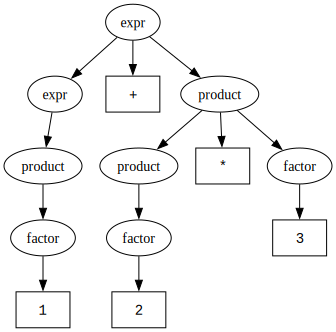

In [14]:
test_parser('simple.g', '1 + 2 * 3')

In [15]:
!cat simple.g

expr: expr '+' product;
expr: product;
    
product: product '*' factor;
product: factor;
       
factor: '(' expr ')';
factor: NUMBER;


In [16]:
!cat ambiguous.g

expr: expr '+' expr;
expr: expr '*' expr;
expr: '(' expr ')';
expr: NUMBER;


--- Loading Grammar ---
Grammar:

expr: ['expr', '+', 'expr'];
expr: ['expr', '*', 'expr'];
expr: ['(', 'expr', ')'];
expr: ['NUMBER'];

Input: [None, ('NUMBER', '1'), ('+', '+'), ('NUMBER', '2'), ('*', '*'), ('NUMBER', '3')]

starting...
________________________________________________________________________________
next token = ('NUMBER', '1')
________________________________________________________________________________
prediction:
<expr →  • expr + expr, 0> added to Q0
<expr →  • expr * expr, 0> added to Q0
<expr →  • ( expr ), 0> added to Q0
<expr →  • NUMBER, 0> added to Q0
scanning:
<expr → NUMBER • , 0> added to Q1

Q0:
<Start →  • expr, 0>
<expr →  • expr + expr, 0>
<expr →  • expr * expr, 0>
<expr →  • ( expr ), 0>
<expr →  • NUMBER, 0>

Q1:
<expr → NUMBER • , 0>
________________________________________________________________________________
next token = ('+', '+')
________________________________________________________________________________
completion:
<Start → expr •

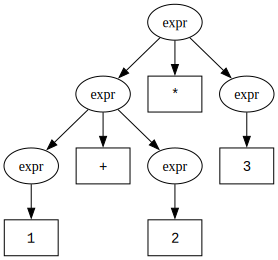

Tree 2: ('expr', [('expr', ['1']), '+', ('expr', [('expr', ['2']), '*', ('expr', ['3'])])])


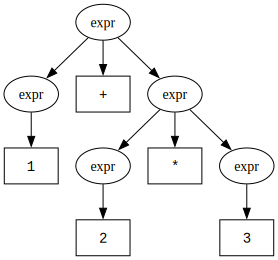

In [17]:
test_parser('ambiguous.g', '1 + 2 * 3')